In [2]:
import os
os.chdir("C:\\Users\\TEJAS KUMAR V URS\\Desktop\\Miniclip\\data")

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind

## Data Exploration

In [4]:
# Load datasets
activity_data = pd.read_csv("data_daily_activity.csv")
purchase_data = pd.read_csv("data_in_app_purchases.csv")

# Display dataset info
print("Activity Data Info:")
print(activity_data.info())

print("\nPurchase Data Info:")
print(purchase_data.info())

# Check for missing values
print("\nMissing Values:")
print(activity_data.isnull().sum())
print(purchase_data.isnull().sum())

Activity Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623982 entries, 0 to 623981
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   dateActivity  623982 non-null  object
 1   abTestGroup   623982 non-null  object
 2   platform      623982 non-null  object
 3   countryCode   623977 non-null  object
 4   userId        623982 non-null  object
dtypes: object(5)
memory usage: 23.8+ MB
None

Purchase Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26410 entries, 0 to 26409
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   productId     26410 non-null  object 
 1   dateActivity  26410 non-null  object 
 2   cost          26268 non-null  float64
 3   userId        26410 non-null  object 
dtypes: float64(1), object(3)
memory usage: 825.4+ KB
None

Missing Values:
dateActivity    0
abTestGroup     0
platform        0
countr

In [5]:
purchase_data.iloc[26286]

productId       promocoinspack3
dateActivity         2019-12-07
cost                        NaN
userId          9xant4q4v9zc11m
Name: 26286, dtype: object

In [6]:
# Imputing NaN values with mode method basis ProductID costs
purchase_data['cost'] = purchase_data.groupby('productId')['cost'].transform(lambda x: x.fillna(x.mode().iloc[0]))

## Exploratory Data Analysis (EDA)

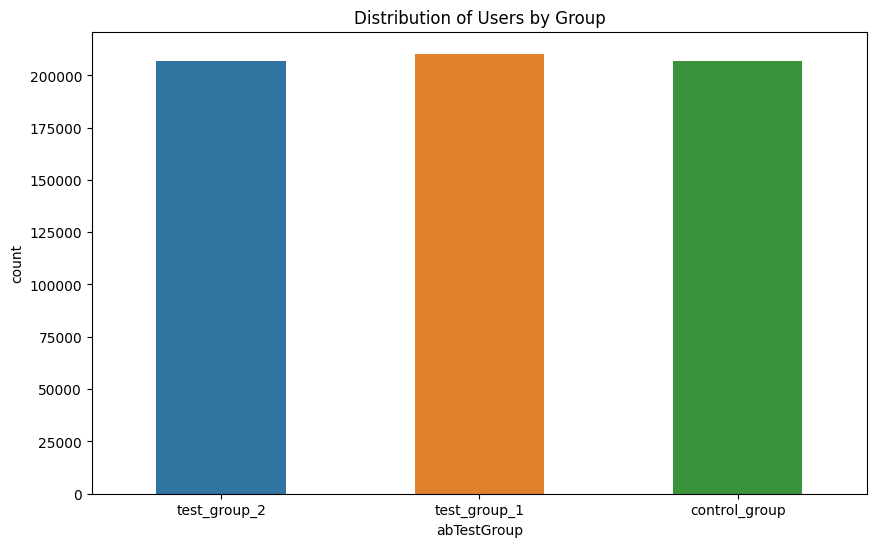

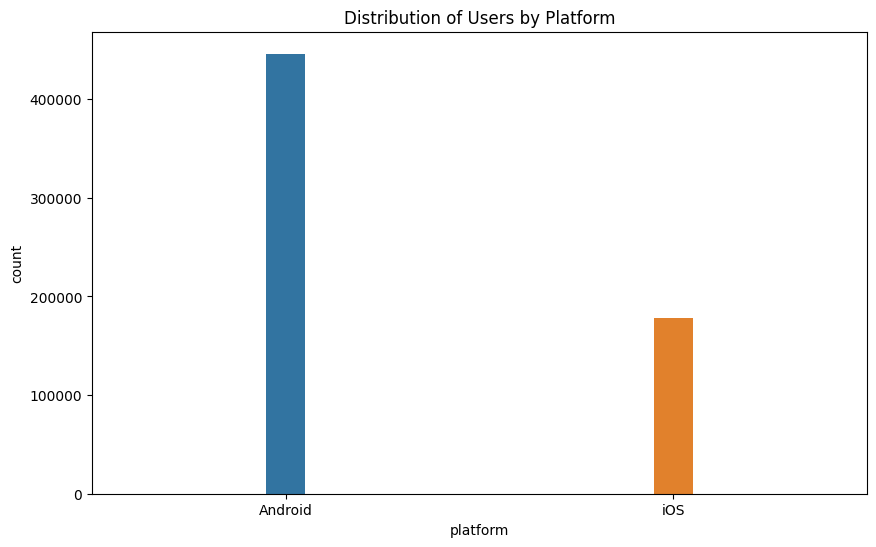

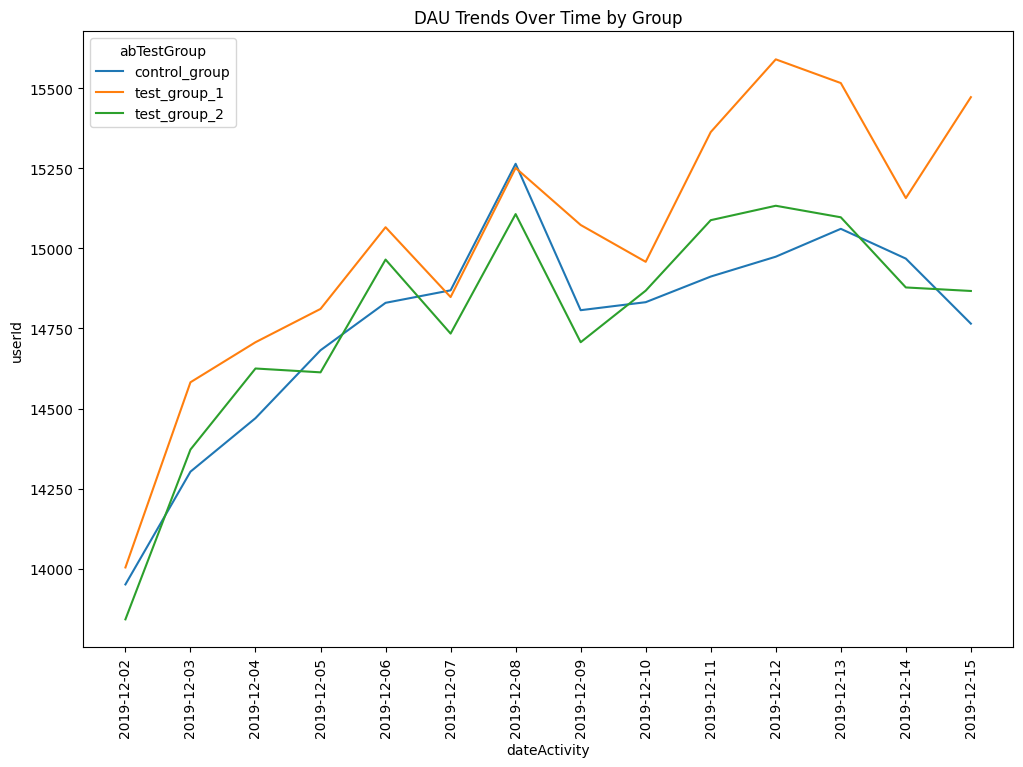

In [7]:
# Explore DAU distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='abTestGroup', data=activity_data, width=0.5)
plt.title('Distribution of Users by Group')
plt.show()


plt.figure(figsize=(10, 6))
sns.countplot(x='platform', data=activity_data, width=0.1)
plt.title('Distribution of Users by Platform')
plt.show()

# Explore DAU trends over time
plt.figure(figsize=(12, 8))
sns.lineplot(x='dateActivity', y='userId', hue='abTestGroup', data=activity_data.groupby(['dateActivity', 'abTestGroup']).count().reset_index())
plt.title('DAU Trends Over Time by Group')
plt.xticks(rotation=90)
plt.show()


## Merging Datasets

In [172]:
# Acticity Dataset
# Group data by 'userId' and 'dateActivity' and count occurrences
compact_act = activity_data.groupby(['userId', 'dateActivity']).size().reset_index(name='count')

#Interim data to get other details of users
interim_act = activity_data.groupby('userId',).agg({
    'abTestGroup': 'first',
    'platform': 'first',
    'countryCode': 'first',
}).reset_index()

compact_act = pd.merge(compact_act, interim_act, on=['userId'], how='left')
compact_act

# Purchase Dataset
compact_purc = purchase_data.groupby(['userId', 'dateActivity','productId']).agg({
    'cost': 'sum'
}).reset_index()
interim_purc = activity_data.groupby(['userId']).agg({'abTestGroup':'first',
                                                'countryCode':'first',
                                                'platform':'first'})

purc_groups = pd.merge(compact_purc,interim_purc,on=['userId'],how='left')

## Revenue Analysis

In [173]:
# Calculate ARPDAU
activity_data['dateActivity'] = pd.to_datetime(activity_data['dateActivity'])
purc_groups['dateActivity'] = pd.to_datetime(purchase_data['dateActivity'])

daily_revenue = purc_groups.groupby(['dateActivity','abTestGroup'])['cost'].sum()
daily_dau = activity_data.groupby(['dateActivity', 'abTestGroup'])['userId'].nunique()

arpdau = daily_revenue / daily_dau
arpdau

dateActivity  abTestGroup  
2019-12-02    control_group    0.274911
              test_group_1     0.295250
              test_group_2     0.337901
2019-12-03    control_group    0.277743
              test_group_1     0.291118
              test_group_2     0.366254
2019-12-04    control_group    0.250666
              test_group_1     0.235307
              test_group_2     0.284661
2019-12-05    control_group    0.246613
              test_group_1     0.251084
              test_group_2     0.240503
2019-12-06    control_group    0.251806
              test_group_1     0.294489
              test_group_2     0.271987
2019-12-07    control_group    0.230696
              test_group_1     0.255408
              test_group_2     0.292442
2019-12-08    control_group    0.239032
              test_group_1     0.255375
              test_group_2     0.260806
2019-12-09    control_group    0.270077
              test_group_1     0.237036
              test_group_2     0.257357
2019-12-10  

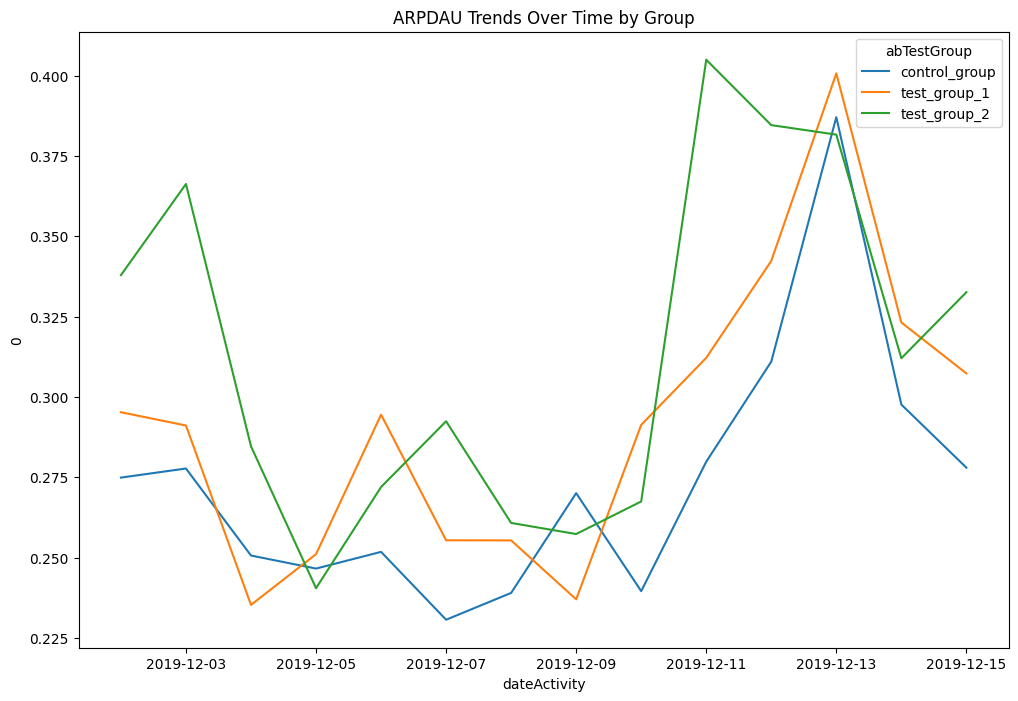

In [174]:
# Assuming your ARDPAU data is named arpdau

# Reset the index of the ARDPAU DataFrame
arpdau_reset = arpdau.reset_index()

# Plotting ARDPAU after resetting the index
plt.figure(figsize=(12, 8))
sns.lineplot(x='dateActivity', y=0, hue='abTestGroup', data=arpdau_reset)
plt.title('ARPDAU Trends Over Time by Group')
plt.show()

## Hypothesis Testing

### Entire Game Revenue

In [182]:
# Perform t-test between control and test groups on Product cost
control_group = purc_groups[purc_groups['abTestGroup'] == 'control_group']['cost']
test_group_1 = purc_groups[purc_groups['abTestGroup'] == 'test_group_1']['cost']
test_group_2 = purc_groups[purc_groups['abTestGroup'] == 'test_group_2']['cost']

# t-test values
t_stat_1, p_value_1 = ttest_ind(control_group, test_group_1)
t_stat_2, p_value_2 = ttest_ind(control_group, test_group_2)

# Display the results
print(f'Test Group 1 vs Control Group: t-statistic = {t_stat_1}, p-value = {p_value_1}')
print(f'Test Group 2 vs Control Group: t-statistic = {t_stat_2}, p-value = {p_value_2}')

Test Group 1 vs Control Group: t-statistic = 4.8377769122250704, p-value = 1.3282098418435439e-06
Test Group 2 vs Control Group: t-statistic = -4.065713843457975, p-value = 4.819454516262567e-05


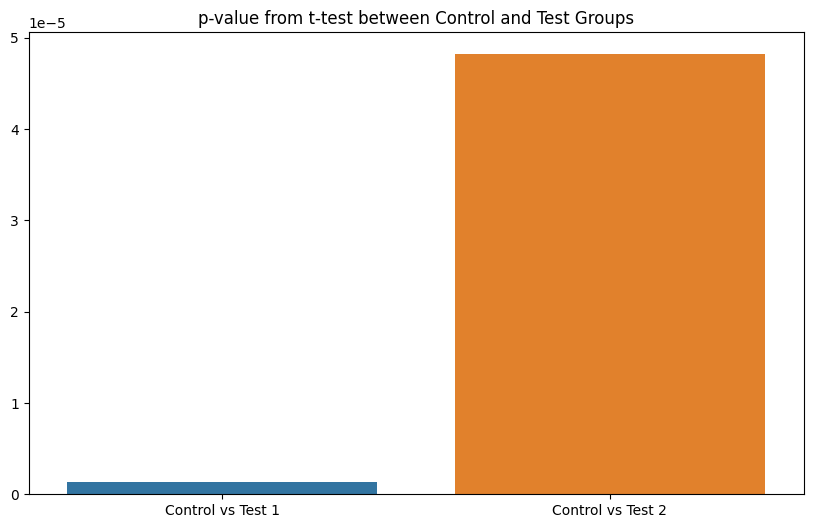

In [183]:
# Visulaizing ttest results
plt.figure(figsize=(10, 6))
sns.barplot(x=['Control vs Test 1', 'Control vs Test 2'], y=[p_value_1, p_value_2])
plt.title('p-value from t-test between Control and Test Groups')
plt.show()

In [184]:
# Reset the index of the ARDPAU DataFrame
arpdau_reset = arpdau.reset_index()

# Extract data for each test group
control_group = arpdau_reset.loc[arpdau_reset['abTestGroup'] == 'control_group', 0]
test_group_1 = arpdau_reset.loc[arpdau_reset['abTestGroup'] == 'test_group_1', 0]
test_group_2 = arpdau_reset.loc[arpdau_reset['abTestGroup'] == 'test_group_2', 0]

# Perform t-test between control_group and test_group_1 on ARPDAU
t_stat_1, p_value_1 = ttest_ind(control_group, test_group_1, equal_var=False)

# Perform t-test between control_group and test_group_2 on ARPDAU
t_stat_2, p_value_2 = ttest_ind(control_group, test_group_2, equal_var=False)

# Display the results
print(f'Test Group 1 vs Control Group: t-statistic = {t_stat_1}, p-value = {p_value_1}')
print(f'Test Group 2 vs Control Group: t-statistic = {t_stat_2}, p-value = {p_value_2}')

Test Group 1 vs Control Group: t-statistic = -1.1390115007361399, p-value = 0.2652331477560467
Test Group 2 vs Control Group: t-statistic = -2.2230194718689362, p-value = 0.03591186607638541


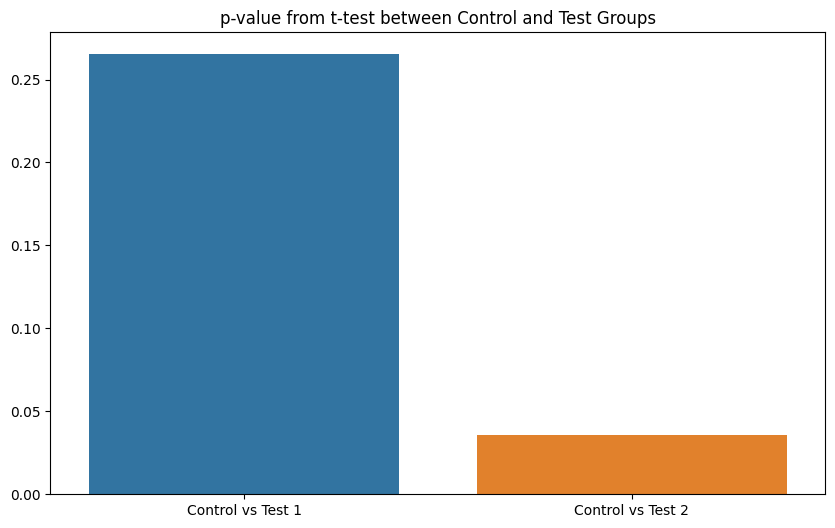

In [185]:
# Visulaizing ttest results
plt.figure(figsize=(10, 6))
sns.barplot(x=['Control vs Test 1', 'Control vs Test 2'], y=[p_value_1, p_value_2])
plt.title('p-value from t-test between Control and Test Groups')
plt.show()

### Goldengoal IAP Revenue

In [186]:
# Filter only Goldengoal IAP from entire data
ID_list = ['goldengoal','goldengoalb']
GG_IAP = purc_groups[purc_groups['productId'].isin(ID_list)]

# Perform t-test between control and test groups on Product cost
control_group = GG_IAP[purc_groups['abTestGroup'] == 'control_group']['cost']
test_group_1 = GG_IAP[purc_groups['abTestGroup'] == 'test_group_1']['cost']
test_group_2 = GG_IAP[purc_groups['abTestGroup'] == 'test_group_2']['cost']

# t-test values
t_stat_1, p_value_1 = ttest_ind(control_group, test_group_1)
t_stat_2, p_value_2 = ttest_ind(control_group, test_group_2)

# Display the results
print(f'Test Group 1 vs Control Group: t-statistic = {t_stat_1}, p-value = {p_value_1}')
print(f'Test Group 2 vs Control Group: t-statistic = {t_stat_2}, p-value = {p_value_2}')

Test Group 1 vs Control Group: t-statistic = 19.40161825346535, p-value = 6.444568647573017e-77
Test Group 2 vs Control Group: t-statistic = -9.311141626891995, p-value = 6.583893185050431e-20


C:\Users\TEJAS KUMAR V URS\AppData\Local\Temp\ipykernel_21080\3378272317.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  control_group = GG_IAP[purc_groups['abTestGroup'] == 'control_group']['cost']
C:\Users\TEJAS KUMAR V URS\AppData\Local\Temp\ipykernel_21080\3378272317.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_group_1 = GG_IAP[purc_groups['abTestGroup'] == 'test_group_1']['cost']
C:\Users\TEJAS KUMAR V URS\AppData\Local\Temp\ipykernel_21080\3378272317.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_group_2 = GG_IAP[purc_groups['abTestGroup'] == 'test_group_2']['cost']


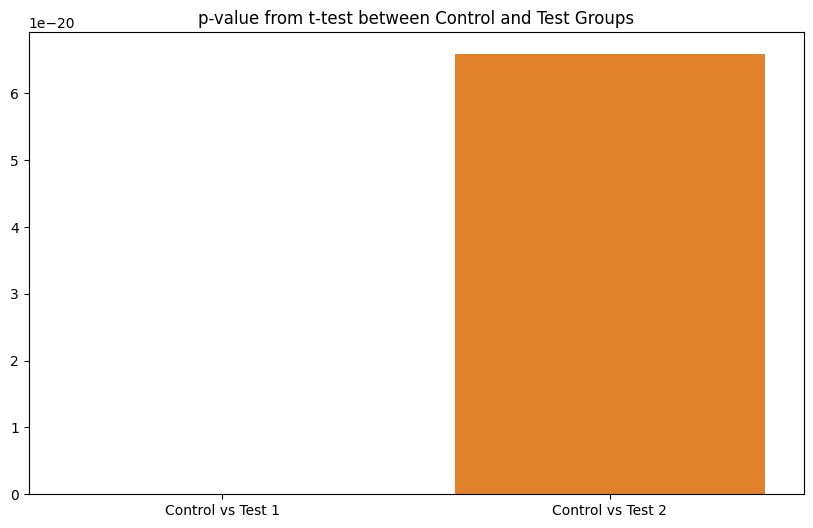

In [187]:
# Visulaizing ttest results
plt.figure(figsize=(10, 6))
sns.barplot(x=['Control vs Test 1', 'Control vs Test 2'], y=[p_value_1, p_value_2])
plt.title('p-value from t-test between Control and Test Groups')
plt.show()